Tutorial: [Data Container](https://docs.pymc.io/notebooks/data_container.html)

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import arviz as az
from theano import shared

print('Running with PyMC3 version v.{}'.format(pm.__version__))

Running with PyMC3 version v.3.8


In [2]:
az.rcParams['stats.credible_interval'] = 0.89
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['legend.fontsize']=12
plt.rcParams['axes.labelsize']=12
plt.rcParams['axes.titlesize']=12
plt.rcParams['figure.titlesize']=15

### The `Data` class
The Data container class wraps the theano shared variable class and let the model be aware of its inputs and outputs. This allows one to change the value of an observed variable to predict or refit on new data. All variables of this class must be declared inside a model context and specify a name for them.

In [7]:
true_mu = 30
observed_data = true_mu + np.random.randn(10)

with pm.Model() as model:
    data = pm.Data("data", observed_data)
    mu = pm.Normal('mu', 0, 10)
    y=pm.Normal('y', mu=mu, sigma=1, observed=data)
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 5535.72draws/s]
The acceptance probability does not match the target. It is 0.8844512808350107, but should be close to 0.8. Try to increase the number of tuning steps.


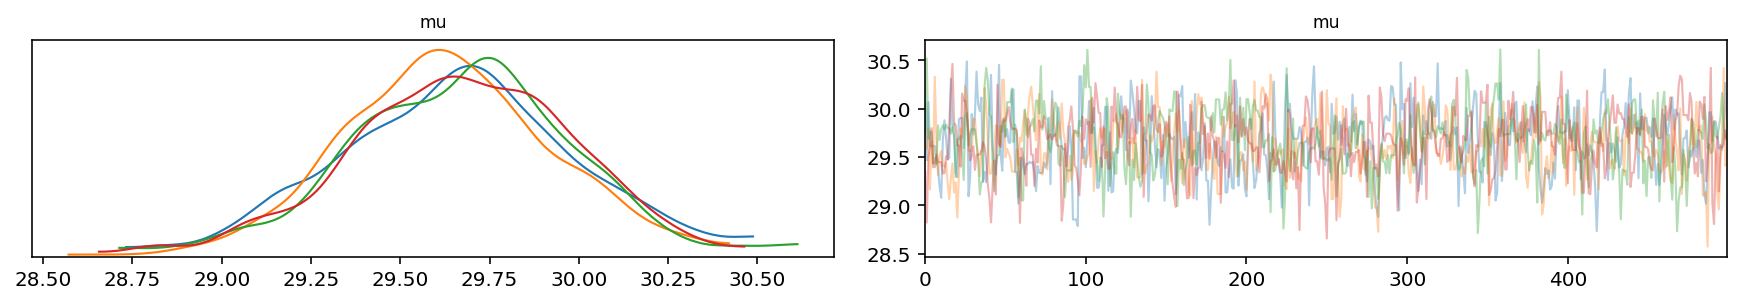

In [9]:
az.plot_trace(trace)
pass

In [15]:
model['data'].get_value()

array([30.26654032, 30.53560709, 30.03219369, 29.76674737, 30.10295036,
       28.65812082, 28.86830596, 29.59347166, 28.96590748, 29.94258242])

In [14]:
np.alltrue(model['data'].get_value()==observed_data)

True

In [16]:
type(data)

theano.tensor.sharedvar.TensorSharedVariable

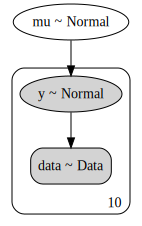

In [18]:
pm.model_to_graphviz(model)

The methods and functions related to the Data container class are:

- `data_container.get_value` (method inherited from the theano SharedVariable): gets the value associated with the data_container.

- `data_container.set_value` (method inherited from the theano SharedVariable): sets the value associated with the data_container.

- `pm.set_data`: PyMC3 function that sets the value associated with each Data container variable indicated in the dictionary new_data with it corresponding new value.

### Fit the same model to several datasets
We can use Data container variables in PyMC3 to fit the same model to several datasets without the need to recreate the model each time (which can be time consuming if the number of datasets is large):

In [52]:
# generate 10 datasets
true_mu = np.random.randn(10,1)
observed_data = true_mu + np.random.randn(1,20)

# train model
with pm.Model() as model:
    data = pm.Data('data', observed_data[0])
    mu = pm.Normal('mu', 0, 10)
    pm.Normal('y', mu=mu, sigma=1, observed=data)
    
# generate one trace for each data set
traces = []
for data_vals in observed_data:
    with model:
        pm.set_data({'data': data_vals})
        traces.append(pm.sample())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 5298.67draws/s]
The acceptance probability does not match the target. It is 0.8867557303571834, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 5317.42draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 5127.52draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000

Each time `data container` is reset, `pm.sample` will use the new data for the likelihood, overwriting & ignoring the previous datasets. The new data is not used as additional info to the model, but as a brand new input in `pm.sample`. That's different from `pm.sample_posterior_predictive`.

In [67]:
print('true\t\t\tpp_mu')
list(zip(np.ravel(true_mu), [trace_i['mu'].mean() for trace_i in traces]))

true			pp_mu


[(-3.6793777704618265, -3.731896121320283),
 (-0.6250265836884469, -0.6868762599206081),
 (1.6966725166232035, 1.6311255583461501),
 (0.5930316413974496, 0.5334427861965562),
 (1.0469393923336343, 0.9928426936155499),
 (-1.2926003033694284, -1.3240316844605162),
 (-1.5092175183885508, -1.5517061057472756),
 (0.2356242102866054, 0.19034926280969158),
 (-0.4975556691261983, -0.5565995793329107),
 (0.5802343806949498, 0.5453400214330395)]

### Predict on new data

We can also sometimes use Data container variables to work around limitations in the current PyMC3 API. A common task in Machine Learning is to predict values for unseen data, and one way to achieve this is to use a Data container variable for our observations:

In [69]:
x = np.random.randn(100)
y = x > 0

with pm.Model() as model:
    x_shared = pm.Data('x_shared', x)
    coeff = pm.Normal('x', mu=0, sigma=1)
    logistic = pm.math.sigmoid(coeff * x_shared)
    pm.Bernoulli('obs', p=logistic, observed=y)
    
    # fit model
    trace = pm.sample()

INFO (theano.gof.compilelock): Refreshing lock /Users/huishi/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 4768.17draws/s]


In [70]:
new_values = [-1, 0, 1.]
with model:
    # Switch out the observations and use `sample_posterior_predictive` to predict
    pm.set_data({'x_shared': new_values})
    post_pred = pm.sample_posterior_predictive(trace, samples=500)

/Applications/anaconda3/envs/stats/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:00<00:00, 764.24it/s]


In [75]:
post_pred['obs'].shape

(500, 3)

In [74]:
post_pred['obs'].mean(axis=0)

array([0.034, 0.45 , 0.976])

### Applied Example: height of toddlers as a function of age

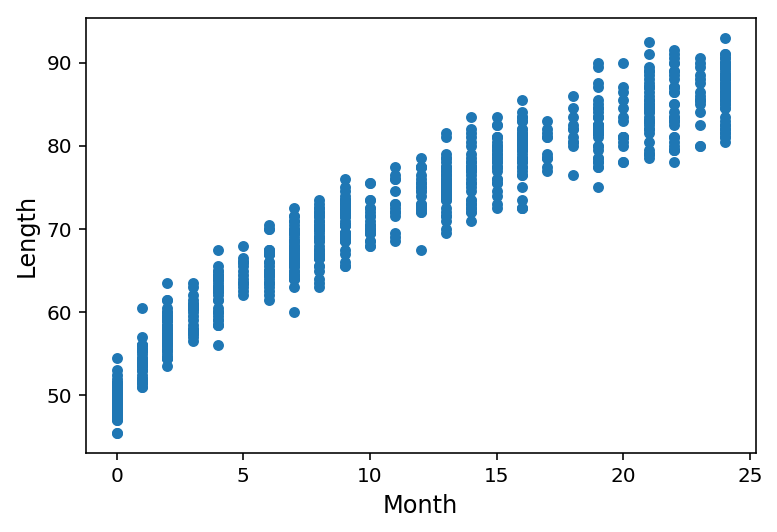

In [76]:
data = pd.read_csv(pm.get_data('babies.csv'))
data.plot.scatter('Month', 'Length')

In [79]:
with pm.Model() as model_babies:
    alpha = pm.Normal('alpha', sigma=10)
    beta = pm.Normal('beta', sigma=10)
    gamma = pm.HalfNormal('gamma', sigma=10)
    delta = pm.HalfNormal('delta', sigma=10)
    
    month = pm.Data('month', data.Month.values)
    
    mu = pm.Deterministic('mu', alpha + beta * month**0.5)
    epsilon = pm.Deterministic('epsilon', gamma + delta * month)
    y_pred = pm.Normal('y_pred', mu=mu, sigma=epsilon, observed=data.Length)
    
    trace_babies = pm.sample(1000)

INFO (theano.gof.compilelock): Refreshing lock /Users/huishi/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.7.6-64/lock_dir/lock
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, gamma, beta, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:03<00:00, 1656.79draws/s]
The acceptance probability does not match the target. It is 0.8867727007056577, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9368458496888917, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8903616307209354, but should be close to 0.8. Try to increase the number of tuning steps.


The following figure shows the result of our model. The mean of 𝜇 is represented with a black curve, and two semitransparent orange bands represent 1 and 2 standard deviations.

In [85]:
trace_babies['beta'].shape

(4000,)

In [86]:
trace_babies['mu'].shape

(4000, 800)

In [113]:
az.summary(trace_babies, var_names=["~mu", "~epsilon"], kind="stats")

,mean,sd,hpd_5.5%,hpd_94.5%
alpha,46.927,0.234,46.567,47.314
beta,7.968,0.076,7.841,8.083
gamma,2.389,0.120,2.197,2.576
delta,0.038,0.010,0.022,0.053


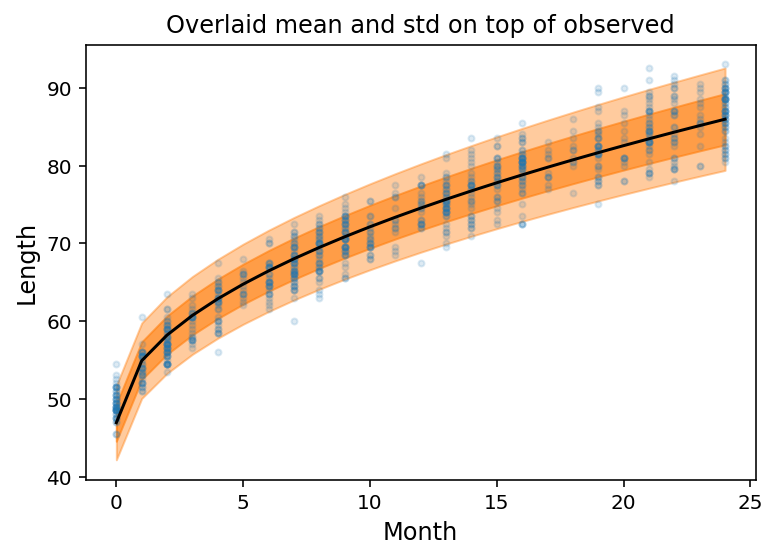

In [89]:
plt.plot(data.Month, data.Length, 'C0.', alpha=0.15)
mu_m = trace_babies['mu'].mean(0)
epsilon_m = trace_babies['epsilon'].mean(0)
plt.plot(data.Month, mu_m, c='k')
plt.fill_between(data.Month, mu_m + 1 * epsilon_m, mu_m - 1 * epsilon_m, 
                 alpha=0.6, color='C1')
plt.fill_between(data.Month, mu_m + 2 * epsilon_m, mu_m - 2 * epsilon_m, 
                 alpha=0.4, color='C1')
plt.xlabel("Month")
plt.ylabel("Length")
plt.title("Overlaid mean and std on top of observed")
pass

In [119]:
mu_m = trace_babies['mu'].mean(0)
mu_hpd = az.hpd(trace_babies['mu'])

with model_babies:
    pm.set_data({"month": np.arange(0, 26)})
    ppc_length = pm.sample_posterior_predictive(trace_babies, samples=1000, model=model_babies)
y_pred_m = ppc_length['y_pred'].mean(0)
y_pred_hpd = az.hpd(ppc_length['y_pred'])

/Applications/anaconda3/envs/stats/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 1000/1000 [00:02<00:00, 437.16it/s]


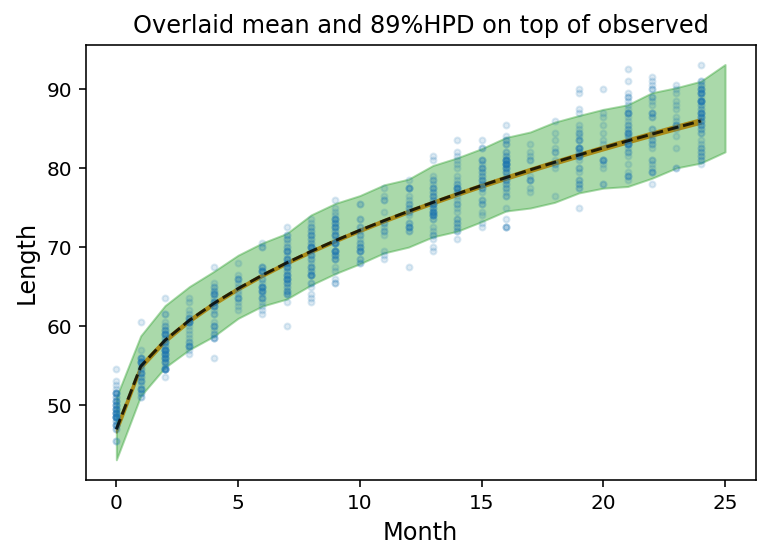

In [132]:
plt.plot(data.Month, data.Length, 'C0.', alpha=0.15)

plt.plot(data.Month, mu_m, 'k--', alpha=0.8)
plt.fill_between(data.Month, mu_hpd[:,0], mu_hpd[:,1],
                color='C1')
plt.fill_between(np.arange(0,26), y_pred_hpd[:, 0], y_pred_hpd[:, 1],
                 alpha=0.4, color='C2')
plt.xlabel("Month")
plt.ylabel("Length")
plt.title("Overlaid mean and 89%HPD on top of observed")
pass

A baby is two week old. How is her length compared to the growth chart we have created?

One way to answer this question is to ask the model for the distribution of the variable length for babies of 0.5 months. Using PyMC3 we can ask this questions with the function sample_posterior_predictive , as this will return samples of Length conditioned on the obseved data and the estimated distribution of parameters, that is including uncertainties. The only problem is that by default this function will return predictions for Length for the observed values of Month, and 0.5 months (the value he cares) has not been observed, all measures are reported for integer months. The easier way to get predictions for non-observed values of Month is to define a Data container variable (as part of the model) and then update the value of the variable right before sampling from the posterior predictve distribution.

In [133]:
with model_babies:
    pm.set_data({'month': [0.5]})
    y_ppc = pm.sample_posterior_predictive(trace_babies, 2000)

/Applications/anaconda3/envs/stats/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 2000/2000 [00:02<00:00, 855.06it/s]


Why isn't the shape (2000, 1) ?? Since now there is only one input.

In [135]:
y_ppc['y_pred'].shape

(2000, 800)

Below I just followed the steps the tutorial did. Although pairing up the y_ppc 1st column with my previous ppcs looks about right.

In [137]:
y_ppc = y_ppc['y_pred'][:, 0]

In [146]:
list(zip(['0 month', '0.5 month', '1 month'], np.round([ppc_length['y_pred'][:, 0].mean(0), y_ppc.mean(0), ppc_length['y_pred'][:, 1].mean(0)],2)))

[('0 month', 46.92), ('0.5 month', 52.6), ('1 month', 54.98)]

Now we can plot the expected distribution of lengths for babies with 2 weeks old and compute additional quantities for example the percentile of a child given her length:

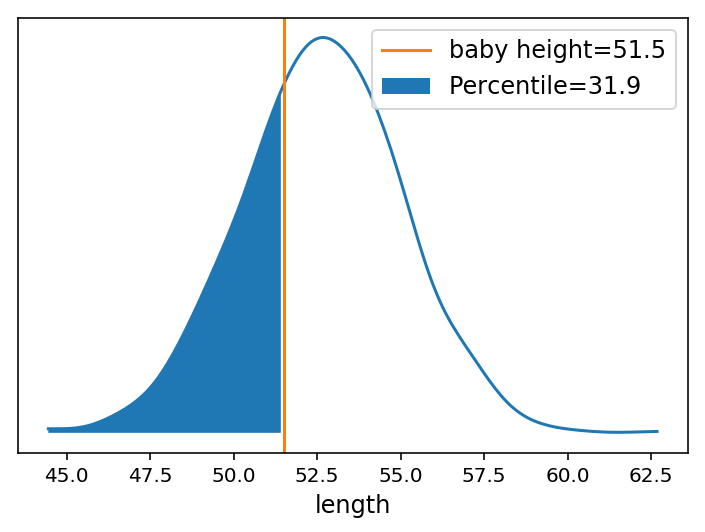

In [163]:
ref_baby = 51.5
percentile = np.mean(y_ppc<=ref_baby)

density, l, u = az.plots._fast_kde(y_ppc)
x_ = np.linspace(l, u, len(density))
plt.plot(x_, density)
plt.fill_between(x_[x_<=ref_baby], density[x_<=ref_baby], 
                label=f"Percentile={percentile*100:.1f}")
plt.xlabel('length')
plt.axvline(x=ref_baby, label=f'baby height={ref_baby}', color='C1')
plt.yticks([])
plt.legend()